In [ ]:
from collections import Counter
from abc import ABC, abstractclassmethod, abstractmethod
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.max_rows",4999)

In [ ]:


class FederalRates(ABC):
    
    def __init__(self, fundRate, inflation):
        try: 
            self.fundRate = fundRate
            self.inflation = inflation
            super(FederalRates, self).__init__()
        except AttributeError as e:
            print(e)
            
    @abstractmethod
    def predict(self):
        return self.__init__() 
    
    @abstractmethod
    def testValues(self):
        return self.__init__() 

    @classmethod
    def readData(cls, path):
        rawData = pd.read_csv(path)
        return (rawData)


        


In [126]:
def describes(rawInterestRateData, rawInflationRateData):
    testInterestRate = TestInterestRate(FederalRates.readData(rawInterestRateData), FederalRates.readData(rawInflationRateData))
    return print(testInterestRate.predict())

describes("./FF.csv", "./index.csv")

count    99.000000
mean      2.018485
std       0.346099
min       1.370000
25%       1.700000
50%       2.120000
75%       2.390000
max       2.440000
Name: FF, dtype: float64


# Forecasting Fund Rates with Our Dataset with Auto regressive Model #

*** Please note that in this prediction model other parameters like CPI, SMPI, II and Sentimental Analytics are not included. This is only to demonstrate and forecasting future values by applying given model. ***

### What is an ARIMA model? ###

Arima model is a class of statistical models for analyzing and forecasting time series since our variable is depending on the time.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

**ARIMA** is an acronym that stands for **AutoRegressive Integrated Moving Average**. It is a generalization of the simpler **AutoRegressive Moving Average** and adds the notion of integration.

1) **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

2) **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

3) **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

### Describing our equation ###

Our main purpose is to predict from ŷ to y value. for this we need to create matrix design which part of the geometric series. It would be much better to review and understand the behavior of the partial derivates, newtons method and geometric series.

**ŷt   =   μ + ϕ1 yt-1 +…+ ϕp yt-p - θ1et-1 -…- θqet-q**

1) To identify the appropriate ARIMA model for Y, you begin by determining the order of differencing (d) needing to stationarize the series and remove the gross features of seasonality, perhaps in conjunction with a variance-stabilizing transformation such as logging or deflating. 

2) If you stop at this point and predict that the differenced series is constant, you have merely fitted a random walk or random trend model. However, the stationarized series may still have autocorrelated errors, suggesting that some number of AR terms (p ≥ 1) and/or some number MA terms (q ≥ 1) are also needed in the forecasting equation.


In [132]:

class TestInterestRate(FederalRates):
    
    def filtered(self):
        rawInterestRate = self.fundRate["DATE"] > "2018-01-01"
        return self.fundRate[rawInterestRate].set_index("DATE")
    
    def predict(self):
        interestRate = self.filtered()["FF"]    
        freqTable = dict(Counter(interestRate))
        return interestRate .describe()
        
    def StartARIMAForecasting(self, Actual, P, D, Q):
        """
            P — Auto regressive feature of the model
            D — Differencing order
            Q — Moving average feature of the model

        """
        model = ARIMA(Actual, order=(P, D, Q))
        model_fit = model.fit(disp=0)
        prediction = model_fit.forecast()[0]
        return prediction
    
    def testValues(self):
        values = self.filtered()["FF"]
        #predict next value
        predicted = self.StartARIMAForecasting(values, 3,1,0)

        #Use 80% of data as training, rest 20% to Test model
        NumberOfElements = len(values)
        TrainingSize = int(NumberOfElements * 0.7)
        TrainingData = values[0:TrainingSize]
        TestData = values[TrainingSize:NumberOfElements]

        #new arrays to store actual and predictions
        Actual = [x for x in TrainingData]
        Predictions = list()
        Predictions2 = list()


        #in a for loop, predict values using ARIMA model
        for timepoint in range(len(TestData)):
            ActualValue =  TestData[timepoint]
            #forcast value
            Prediction = self.StartARIMAForecasting(Actual, 2,1,0)# second order auto regression    
            print("\n Degree 2\n",'Actual=%f, Predicted=%f' % (ActualValue, Prediction))
            #add it in the list
            Predictions.append(Prediction)
            Prediction2 = self.StartARIMAForecasting(Actual, 3,1,0)# second order auto regression    
            print("\n Degree 3\n",'Actual=%f, Predicted=%f' % (ActualValue, Prediction2))
            #add it in the list
            Predictions2.append(Prediction2)
            Actual.append(ActualValue)

        #Print MSE to see how good the model is
        Error = mean_squared_error(TestData, Predictions)
        print('\n Test Mean Squared Error (smaller the better fit): %.3f' % Error)
        # plot
        plt.subplots(figsize=(19, 8))
        plt.plot(TestData)
        plt.plot(Predictions, color='red')
        plt.plot(Predictions2, color='green', linestyle="dashed")
        plt.xticks(rotation=45)

        plt.show()
                


### Executing our dataset ###

/Users/sadikerisen/opt/anaconda3/envs/forecastingInterestRate/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)
/Users/sadikerisen/opt/anaconda3/envs/forecastingInterestRate/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)



 Degree 2
 Actual=2.440000, Predicted=2.456341

 Degree 3
 Actual=2.440000, Predicted=2.457684

 Degree 2
 Actual=2.400000, Predicted=2.455013

 Degree 3
 Actual=2.400000, Predicted=2.455837

 Degree 2
 Actual=2.380000, Predicted=2.418851

 Degree 3
 Actual=2.380000, Predicted=2.418445

 Degree 2
 Actual=2.390000, Predicted=2.400466

 Degree 3
 Actual=2.390000, Predicted=2.401499

 Degree 2
 Actual=2.380000, Predicted=2.407269

 Degree 3
 Actual=2.380000, Predicted=2.409937

 Degree 2
 Actual=2.390000, Predicted=2.395024

 Degree 3
 Actual=2.390000, Predicted=2.396446

 Degree 2
 Actual=2.370000, Predicted=2.405853

 Degree 3
 Actual=2.370000, Predicted=2.406050

 Degree 2
 Actual=2.370000, Predicted=2.384787

 Degree 3
 Actual=2.370000, Predicted=2.385774

 Degree 2
 Actual=2.380000, Predicted=2.386174

 Degree 3
 Actual=2.380000, Predicted=2.386378

 Degree 2
 Actual=2.400000, Predicted=2.394200

 Degree 3
 Actual=2.400000, Predicted=2.395387

 Degree 2
 Actual=2.410000, Predicted=2

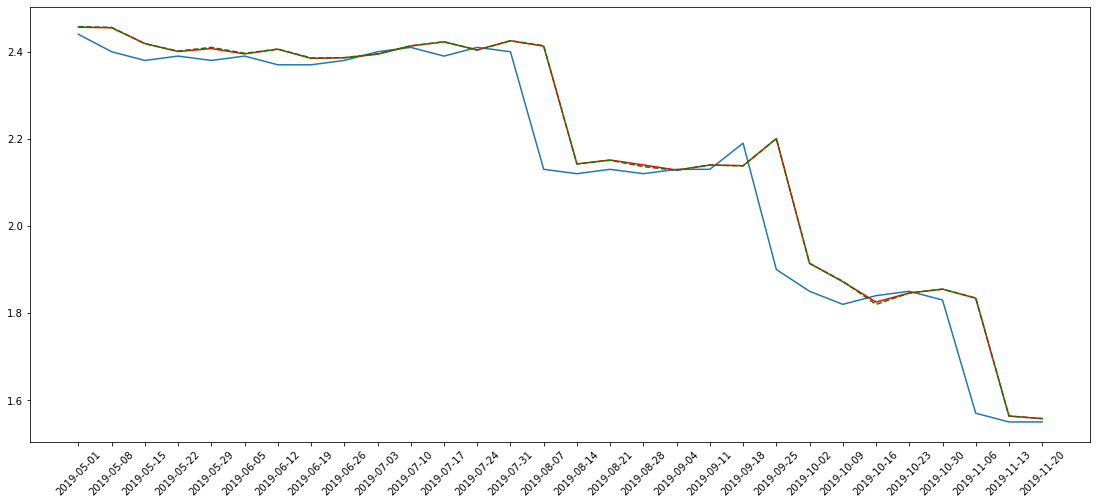

In [133]:
def test(rawInterestRateData, rawInflationRateData):
    testInterestRate = TestInterestRate(FederalRates.readData(rawInterestRateData), FederalRates.readData(rawInflationRateData))
    return testInterestRate.testValues()


test("./FF.csv", "./index.csv")

In [ ]:

class InterestRate(FederalRates):
    
    def filtered(self):
        rawInterestRate = self.fundRate["DATE"] > "2019-05-01"
        return self.fundRate[rawInterestRate].set_index("DATE")
    
    def predict(self):
        interestRate = self.filtered()["FF"]        
        return interestRate.describe()
    
    def testValues(self):
        pass

In [ ]:
def main(rawInterestRateData, rawInflationRateData):
    interestRate = InterestRate(FederalRates.readData(rawInterestRateData), FederalRates.readData(rawInflationRateData))
    return (interestRate.predict())
 
if __name__ == "__main__":
    main("./FF.csv", "./index.csv")